In [ ]:
import json
import openai
import requests
from PIL import Image
from io import BytesIO
import os
from google.colab import userdata
from diffusers import StableDiffusionPipeline
from diffusers import StableDiffusionXLPipeline
from peft import get_peft_model, LoraConfig
import torch
from PIL import Image
from io import BytesIO
import base64
import requests


## Load Json

In [ ]:
# with open(models_water purification.json", "r") as f:
#     data = json.load(f)
# model = data["models"][0]

## Open AI API - dalle-3

In [ ]:
prompt_dalle_3 = """A highly detailed scientific diagram showing the layered structure of a lotus leaf's superhydrophobic surface. The image includes a realistic green lotus leaf at the top with a water droplet beading on it. Below it, an exploded view shows four labeled layers: 1) dense vertical nanohairs (~200 nm) for texture repellency, 2) wax crystals (~100 nm) with a grainy texture to repel water, 3) dome-shaped micro-bumps called papillae (1–5 µm) to reduce contact, and 4) a grid-like air layer (1–5 µm) that traps gas to reduce adhesion. Each layer is visually distinct and arranged in a floating, 3D isometric style with clean typography and gray background, mimicking a professional scientific infographic."""

In [ ]:
horse = """ Create an isometric scientific infographic titled “Horse Leg Locomotion System”. The diagram must feature vertically exploded layers aligned on a central axis, evenly spaced, viewed from a 30° isometric camera angle on both X and Y axes. The background must be flat grey (#CCCCCC) with a light isometric grid. Do not include shadows, icons, or background elements. Title: Horse Leg Locomotion System (in bold, centered above the diagram) Top Layer (Organism): A photo-realistic rendering of a Horse, viewed from above, centered. No environment or background—just the grey grid. Lower Layers (Functional Components in architectural black-and-white line style): Effective Leg Length Left caption: “Effective Leg Length – Longer legs improve stride and efficiency” Right label: 1.24 m (≈60% of body length) Mass Distribution Left caption: “Mass Distribution – Thigh-heavy legs allow faster motion cycles” Right label: "Mesoscale (1 mm – 1 m)" Sagittal Plane 1-DOF Kinematics Left caption: “Single-degree-of-freedom joints stabilize gait and reduce energy loss.” Right label: "Mesoscale (1 mm – 1 m)" Elastic Energy Storage Left caption: “Elastic Storage – Tendons store energy to reduce muscle load” Right label: “Mesoscale (1 mm – 1 m)” Muscle Power Capacity Left caption: “Muscle Power – Multifunctional muscles boost speed and force” Right label: “Mesoscale (1 mm – 1 m)” Visual Style Guidelines: Top Layer: Full-color, photo-realistic rendering of the organism. Centered, no background scene, just neutral grey (#CCCCCC) with grid. Lower Layers: Monochrome architectural line drawings No shading, no lighting, no borders Aligned vertically with equal spacing between layers Maintain strict blueprint or biomimetic schematic aesthetic Ruler: A vertical black ruler on the right side with tick marks aligned to each layer’s height (use approximate scale placement) Captions and Labels: All outside the graphics, horizontally aligned with the vertical center of each layer Do not overlap any visuals"""

In [ ]:
# get
ai_token = userdata.get('ai_token')
client = openai.OpenAI(api_key=ai_token)


In [ ]:
# List all models
models = client.models.list()

# Print model IDs
for model in models.data:
    print(model.id)

gpt-4-0613
gpt-4
gpt-3.5-turbo
gpt-4o-audio-preview-2025-06-03
gpt-4.1-nano
gpt-image-1
codex-mini-latest
gpt-4o-realtime-preview-2025-06-03
davinci-002
babbage-002
gpt-3.5-turbo-instruct
gpt-3.5-turbo-instruct-0914
dall-e-3
dall-e-2
gpt-4-1106-preview
gpt-3.5-turbo-1106
tts-1-hd
tts-1-1106
tts-1-hd-1106
text-embedding-3-small
text-embedding-3-large
gpt-4-0125-preview
gpt-4-turbo-preview
gpt-3.5-turbo-0125
gpt-4-turbo
gpt-4-turbo-2024-04-09
gpt-4o
gpt-4o-2024-05-13
gpt-4o-mini-2024-07-18
gpt-4o-mini
gpt-4o-2024-08-06
chatgpt-4o-latest
o1-preview-2024-09-12
o1-preview
o1-mini-2024-09-12
o1-mini
gpt-4o-realtime-preview-2024-10-01
gpt-4o-audio-preview-2024-10-01
gpt-4o-audio-preview
gpt-4o-realtime-preview
omni-moderation-latest
omni-moderation-2024-09-26
gpt-4o-realtime-preview-2024-12-17
gpt-4o-audio-preview-2024-12-17
gpt-4o-mini-realtime-preview-2024-12-17
gpt-4o-mini-audio-preview-2024-12-17
o1-2024-12-17
o1
gpt-4o-mini-realtime-preview
gpt-4o-mini-audio-preview
o3-mini
o3-mini-2025-

In [ ]:
# Call DALL·E 3
response = client.images.generate(
    model="dall-e-3",
    prompt= horse,
    size="1024x1024",
    quality="standard",  # Cheapest setting
    n=1
)

In [ ]:
# Download and save the image
image_url = response.data[0].url
image_response = requests.get(image_url)
image = Image.open(BytesIO(image_response.content))
#image.save("Dalle_3.png")


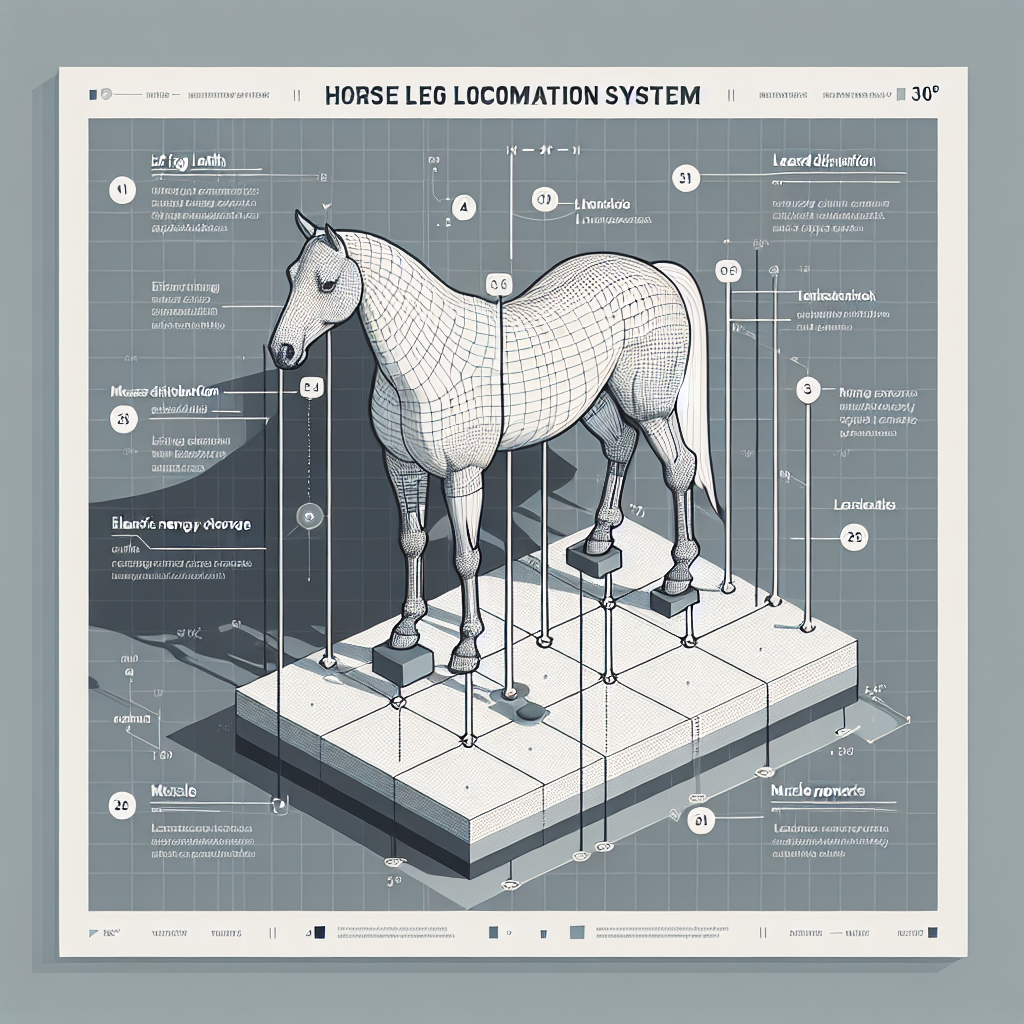

In [ ]:
display(image)

## generate by loop

In [ ]:
layer_prompts = {
    "1_leaf": """A hyper-realistic, full-color rendering of a rounded green lotus leaf seen from above, with visible surface veins and a glossy water droplet in the center.
- Plain solid white background, no shadows.
- Isolated object, centered.
- No text, no side view, no extra elements.
- Isometric camera angle (30° x/y axis).""",

    "2_nanohairs": """A black-and-white isometric line drawing showing dense upright nanohairs, like a tightly packed forest of fine vertical rods on a square tile.
- Plain solid white background, no shadows or borders.
- Isolated object, centered, clean edge.
- No text, no side view, no grid.
- Isometric camera angle (30° x/y axis).
- Style matches blueprint or architectural scientific diagrams.""",

    "3_wax_crystals": """A black-and-white isometric line drawing showing a flat tile covered with frost-like wax crystal texture — granular, irregular, lightly detailed.
- Plain solid white background, no shadows.
- Isolated, centered object with clear outline.
- No text, no side view, no grid.
- Isometric camera angle (30° x/y axis).
- Style matches architectural or blueprint scientific illustrations.""",

    "4_papillae": """A black-and-white isometric line drawing showing dome-shaped papillae arranged in a regular pattern across a square tile, like smooth hemispheres in bubble wrap.
- Plain solid white background, no shadows.
- Isolated, centered object.
- No text, no side view, no grid.
- Isometric camera angle (30° x/y axis).
- Style matches scientific blueprint diagram.""",

    "5_air_layer": """A black-and-white isometric line drawing showing a square grid-like tile with a single spherical droplet hovering just above — representing an air layer.
- Plain solid white background.
- Cleanly separated, centered object.
- No text, no side view, no grid.
- Isometric camera angle (30° x/y axis).
- Blueprint-style architectural scientific illustration."""
}


In [ ]:
def generate_dalle(prompt, filename):
  response = client.images.generate(
    model="dall-e-3",
    prompt=prompt,
    size="1024x1024",
    quality="standard",  # Cheapest setting
    n=1
  )
  image_url = response.data[0].url
  image_response = requests.get(image_url)
  image = Image.open(BytesIO(image_response.content))
  image.save(filename)


In [ ]:
for key, prompt in layer_prompts.items():
    filename = f"{key}.png"
    print(f"🎨 Generating: {key}")
    generate_dalle(prompt, filename)

🎨 Generating: 1_leaf
🎨 Generating: 2_nanohairs
🎨 Generating: 3_wax_crystals
🎨 Generating: 4_papillae
🎨 Generating: 5_air_layer


In [ ]:
!pip install rembg

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 2.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.7/54.7 kB 5.2 MB/s eta 0:00:00


In [ ]:
from PIL import Image, ImageDraw
from rembg import remove

# === Config ===
layer_paths = [
    "1_leaf.png",
    "2_nanohairs.png",
    "3_wax_crystals.png",
    "4_papillae.png",
    "5_air_layer.png"
]

canvas_width = 1080
canvas_height = 1080
layer_spacing = 60
background_color = (204, 204, 204, 255)  # RGBA #CCCCCC

# === Load, remove background, and resize layers ===
layers = []
for i, path in enumerate(layer_paths):
    print(f"🧼 Removing background from {path}")
    img = Image.open(path).convert("RGBA")
    img = remove(img)

    # Optional resizing to simulate depth
    scale = 1.0 - 0.06 * i
    new_size = (int(img.width * scale), int(img.height * scale))
    img = img.resize(new_size, Image.LANCZOS)
    layers.append(img)

# === Compute canvas height ===
total_height = sum(layer.height for layer in layers) + layer_spacing * (len(layers) - 1)
canvas = Image.new("RGBA", (canvas_width, total_height + 100), background_color)
draw = ImageDraw.Draw(canvas)

# === Paste layers vertically centered
y = 50
centers = []

for layer in layers:
    x = (canvas_width - layer.width) // 2
    canvas.paste(layer, (x, y), mask=layer)  # use transparency mask
    centers.append((canvas_width // 2, y + layer.height // 2))
    y += layer.height + layer_spacing

# === Draw vertical construction line
line_color = (0, 0, 0, 255)
for i in range(len(centers) - 1):
    draw.line([centers[i], centers[i + 1]], fill=line_color, width=2)

# === Save result
canvas.save("lotus_infographic_final.png")
print("✅ Saved: lotus_infographic_final.png")


ModuleNotFoundError: No module named 'onnxruntime'